In [207]:
#Import Packages and other functions necessary for all of this to work

# Other Useful General Functions: 
# getcolormap, baseline, getMW, ABSORB, Test_GMM_Clusters
#from generalfunctions import getstats, get_PL_Raman_Current_Voltage_From_Matlab_File, Test_GMM_Clusters
#from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import matplotlib.mlab as mlab
import numpy as np

import datetime

#used to take the derivative of noisy data
from scipy.interpolate import UnivariateSpline

#used to do fitting
from scipy.optimize import leastsq

#used for image segmentation and watershedding
from skimage import data, feature, filters, measure
from skimage.filters import rank
from scipy import ndimage as ndi
from skimage.morphology import watershed, disk

# import clustering algorithms, distance calculations
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA, NMF

#set the useful functions to be used here:
def normalize_spectra_to_1(SPECTRA):
    #takes a matrix N x k where N is the number of observations and k is the number of variables(colums) and normalizes
    #each observation (row) to the maxiumum of all variables (colums)
    max_Spectra = np.ones((SPECTRA.shape[1],1)).dot(np.max(SPECTRA,axis=1)*np.ones((1,SPECTRA.shape[0]))).T
    SPECTRA/= max_Spectra
    return SPECTRA

def scale_spectra_0_1(SPECTRA):
    #takes a matrix N x k where N is the number of observations and k is the number of variables(colums) and scales
    #each observation (row) to range from 0 to 1
    max_Spectra = np.ones((SPECTRA.shape[1],1)).dot(np.max(SPECTRA,axis=1)*np.ones((1,SPECTRA.shape[0]))).T
    min_Spectra = np.ones((SPECTRA.shape[1],1)).dot(np.min(SPECTRA,axis=1)*np.ones((1,SPECTRA.shape[0]))).T
    return (SPECTRA-min_Spectra)/(max_Spectra-min_Spectra)

def lorentzian(x,p):
    #p = [width, center, amplitude]
    numerator =  (p[0]**2 )
    denominator = ( x - (p[1]) )**2 + p[0]**2
    y = p[2]*(numerator/denominator)
    return y

def errorfunc(p,x,z):
        return lorentzian(x,p)-z

def baseline(y, deg=None, max_it=None, tol=None):
    """
    Computes the baseline of a given data.

    Iteratively performs a polynomial fitting in the data to detect its
    baseline. At every iteration, the fitting weights on the regions with
    peaks are reduced to identify the baseline only.

    Parameters
    ----------
    y : ndarray
        Data to detect the baseline.
    deg : int (default: 3)
        Degree of the polynomial that will estimate the data baseline. A low
        degree may fail to detect all the baseline present, while a high
        degree may make the data too oscillatory, especially at the edges.
    max_it : int (default: 100)
        Maximum number of iterations to perform.
    tol : float (default: 1e-3)
        Tolerance to use when comparing the difference between the current
        fit coefficients and the ones from the last iteration. The iteration
    procedure will stop when the difference between them is lower than
    *tol*.

    Returns
    -------
    ndarray
    Array with the baseline amplitude for every original point in *y*
    """
    import math
    import scipy.linalg as LA


    # for not repeating ourselves in `envelope`
    if deg is None: deg = 3
    if max_it is None: max_it = 100
    if tol is None: tol = 1e-3

    order = deg + 1
    coeffs = np.ones(order)

    # try to avoid numerical issues
    cond = math.pow(y.max(), 1. / order)
    x = np.linspace(0., cond, y.size)
    base = y.copy()

    vander = np.vander(x, order)
    vander_pinv = LA.pinv2(vander)

    for _ in range(max_it):
        coeffs_new = np.dot(vander_pinv, y)

        if LA.norm(coeffs_new - coeffs) / LA.norm(coeffs) < tol:
            break

        coeffs = coeffs_new
        base = np.dot(vander, coeffs)
        y = np.minimum(y, base)

    return base

    def envelope(y, deg=None, max_it=None, tol=None):
        """
        Computes the upper envelope of a given data.
        It is implemented in terms of the `baseline` function.

        Parameters
        ----------
        y : ndarray
                Data to detect the baseline.
        deg : int
                Degree of the polynomial that will estimate the envelope.
        max_it : int
                Maximum number of iterations to perform.
        tol : float
                Tolerance to use when comparing the difference between the current
                fit coefficients and the ones from the last iteration.

        Returns
        -------
        ndarray
                Array with the envelope amplitude for every original point in *y*
        """
        return y.max() - baseline(y.max() - y, deg, max_it, tol)

    
def get_PL_Raman_Current_Voltage_From_Matlab_File(fpath):
    import scipy.io
    data = scipy.io.loadmat(fpath, mat_dtype=1) #mat_dtype=1 ensures that vars are imported as arrays
    #print data.keys()
    
    # the string in the brackets references the matlab data file name
    # the data is imported into python as a dictionary and this is how you reference the values
    
    x_coord_array = data['X'] # variable holding the x corrdinates
    y_coord_array = data['Y'] # variable holding the y coordinates

    PL = data["PL"]
    RAMAN = data["RAMAN"]

    wavenumber = data["wavenumber"]
    wavelength = data["wavelength"]

    wn = wavenumber.ravel() # data are imported as N x 1 matricies which complicates plotting later
    wl = wavelength.ravel() # ravel() removes the second dimension so it is an array of length N

    current = data["CURRENT"]
    voltage = data["VOLTAGE"]

    # calculates the step size based on the maximum difference in x and y dirrection to 3 decimal places
    x_step_size = round(np.diff(x_coord_array,axis=0).max(),3) 
    y_step_size = round(np.diff(y_coord_array,axis=0).max(),3) 

    #identifies the number of pixels in both the x and y directions
    x_pixels = int((x_coord_array.max() - x_coord_array.min())/x_step_size + 1)
    y_pixels = int((y_coord_array.max() - y_coord_array.min())/y_step_size + 1)
    
    #converts the number of pixels to a distance in microns based on the stepsize
    x = (np.arange(x_pixels)-x_pixels/2)*x_step_size
    y = (np.arange(y_pixels)-y_pixels/2)*y_step_size

    #send the data back to the user
    return data,PL,RAMAN,wl,wn,current,voltage,x,y,x_pixels,y_pixels   

def find_pl_center(pl_spectra):
    sum_spec = np.cumsum(pl_spectra,axis=1) # calulates the cumulative sum across each row
    norm_sum_spec = sum_spec/np.ones((sum_spec.shape[1],1)).dot(np.max(sum_spec,axis=1)*np.ones((1,sum_spec.shape[0]))).T
    #pp.normalize(sum_spec, 'max', axis = 1, copy = True)

    #where the normalized cumulative sum == 0.5 is the center of the distrubiton
    #subtracting 0.5 from the data and taking the absolute value means that values near 0.5 will be close to zero
    #taking the minimum of this will give you the center position
    find_center_index = np.argmin(np.abs(norm_sum_spec-0.5),axis=1) 

    #generate an empty array to store the energy center values 
    peak_centers = np.ma.empty((norm_sum_spec.shape[0],1))
    for i in range(norm_sum_spec.shape[0]):
        peak_centers[i] = pl_energy_wavelength[find_center_index[i]]
    return peak_centers

def find_pl_intensity_at_center(pl_spectra):
    sum_spec = np.cumsum(pl_spectra,axis=1) # calulates the cumulative sum across each row
    norm_sum_spec = sum_spec/np.ones((sum_spec.shape[1],1)).dot(np.max(sum_spec,axis=1)*np.ones((1,sum_spec.shape[0]))).T
    #pp.normalize(sum_spec, 'max', axis = 1, copy = True)

    #where the normalized cumulative sum == 0.5 is the center of the distrubiton
    #subtracting 0.5 from the data and taking the absolute value means that values near 0.5 will be close to zero
    #taking the minimum of this will give you the center position
    find_center_index = np.argmin(np.abs(norm_sum_spec-0.5),axis=1) 

    #generate an empty array to store the energy center values 
    peak_intensity = np.ma.empty((norm_sum_spec.shape[0],1))
    for i in range(norm_sum_spec.shape[0]):
        peak_intensity[i] = pl_spectra[i,find_center_index[i]]
    return peak_intensity


def FWHM(X,Y):
    half_max = max(Y) / 2.
    max_idx = np.argmax(Y)
    left_idx = np.argmin(np.abs(Y[0:max_idx]-half_max))
    right_idx = np.argmin(np.abs(Y[max_idx::]-half_max))+ max_idx
    return X[right_idx] - X[left_idx] #return the difference (full width)

def get_pl_FWHM(pl_spectra,pl_energy_wavelength):
    pl_FWHM = np.zeros((pl_spectra.shape[0],1)).ravel()
    for i in range(len(pl_FWHM)):
        Y = pl_spectra[i,:]
        X = pl_energy_wavelength
        pl_FWHM[i] = FWHM(X,Y)
    return pl_FWHM

In [2]:
sample_names = ['AIST_saph','AIST_saph_naf','AIST_slg','AIST_slg_naf']

num_samples = len(sample_names)
all_pl_centers = [None]*num_samples
all_x = [None]*num_samples
all_y = [None]*num_samples
all_voltage = [None]*num_samples
all_current = [None]*num_samples
all_pl = [None]*num_samples
all_pl_energy = [None]*num_samples
all_pl_intensity = [None]*num_samples
all_pl_FWHM = [None]*num_samples

for idx,sample_name in enumerate(sample_names):
    file_path_to_renishaw_data = 'F:/Ren_Data/' + sample_name + '.mat'

    #use parenthesis to break long lines of code over multiple lines
    (dictionary_of_matlab_variables, 
     pl_spectra, raman_spectra, 
     pl_energy_wavelength, raman_energy_wavenumber, 
     current_amps, voltage_volts, 
     x_distance_um, y_distance_um, 
     number_of_x_pixels, number_of_y_pixels) = get_PL_Raman_Current_Voltage_From_Matlab_File(file_path_to_renishaw_data)
    
    all_x[idx] = x_distance_um
    all_y[idx] = y_distance_um
    peak_centers = find_pl_center(pl_spectra)
    all_pl_centers[idx] = np.array(peak_centers)
    all_voltage[idx] = np.array(voltage_volts)
    all_current[idx] = np.array(current_amps)
    all_pl[idx] = np.array(pl_spectra)
    all_pl_energy[idx] = np.array(pl_energy_wavelength)
    all_pl_intensity[idx] = find_pl_intensity_at_center(pl_spectra)
    all_pl_FWHM[idx] = get_pl_FWHM(pl_spectra,pl_energy_wavelength)

# Split Data Based on Peak Center

	 Sample 	 Mean Eg (eV) 	 Max Eg (eV) 	 Min Eg (eV) 	 1sigma Range 	 Sigma (meV)
	AIST_saph 	1.15 		1.18 	 	1.08 		1.13 -- 1.17 		17.0
	AIST_saph_naf 	1.18 		1.2 	 	1.09 		1.17 -- 1.19 		10.0
	AIST_slg 	1.17 		1.19 	 	1.15 		1.16 -- 1.17 		5.0
	AIST_slg_naf 	1.17 		1.18 	 	1.16 		1.17 -- 1.17 		3.0


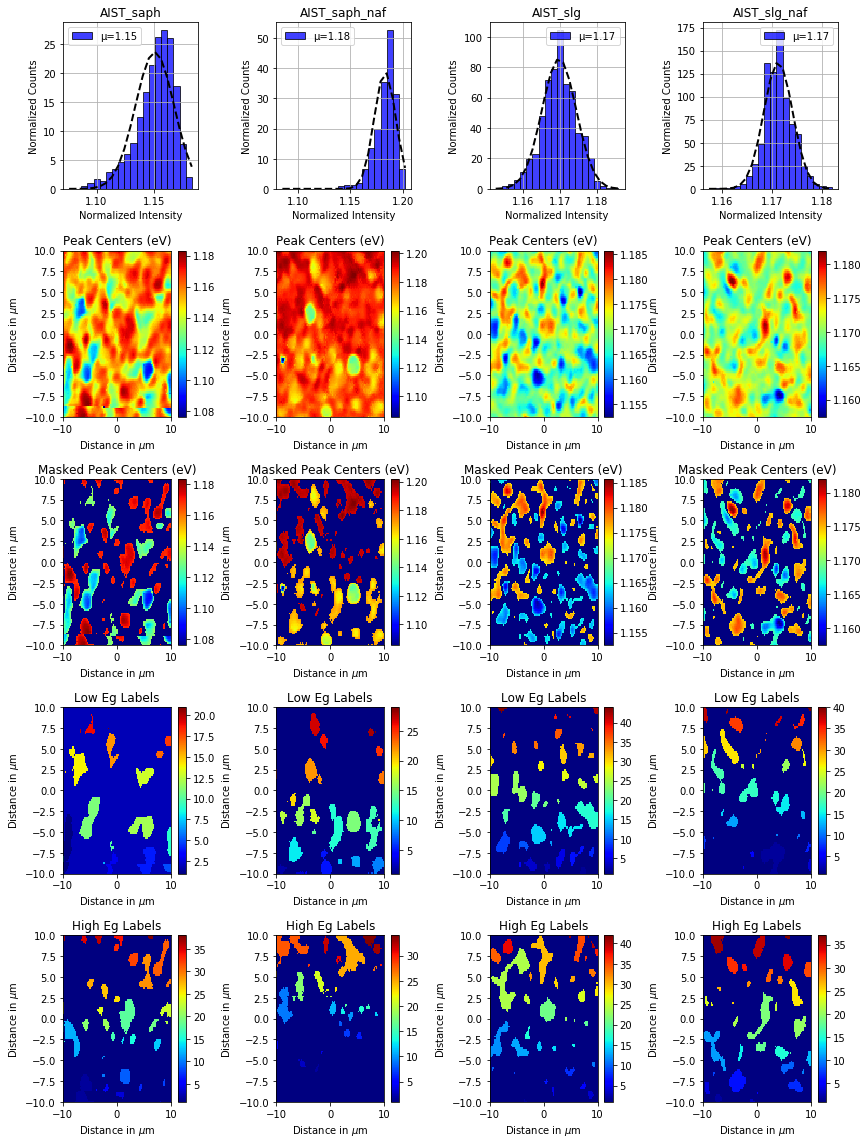

In [3]:
## mean, sigma, size, number
h_data = [None]*num_samples
l_data = [None]*num_samples

num_rows = 5
fig_size = 16

fig, axes = plt.subplots(num_rows,num_samples,figsize=(fig_size*num_samples/num_rows,fig_size))
ax = axes.ravel()

print('\t Sample \t Mean Eg (eV) \t Max Eg (eV) \t Min Eg (eV) \t 1sigma Range \t Sigma (meV)')
for idx in range(num_samples):    
    peak_centers = 1240/all_pl_centers[idx]
    v = all_voltage[idx]
    c = all_current[idx]
    
    x = all_x[idx]
    y = all_y[idx]
    
    mu = np.mean(peak_centers)
    sigma = np.std(peak_centers)


    ##### MASK PEAK CENTERS AT MEAN +/- 1 SIGMA ########
    low = mu - sigma
    high = mu + sigma
    stamp = (peak_centers < low) | (peak_centers > high)
    doi = np.array(peak_centers)
    #print stamp.reshape(number_of_x_pixels,number_of_y_pixels)
    doi[stamp == False] = 0
    
    ##### PRINT OUT DATA FOR EACH SCAN

    print '\t', sample_names[idx],'\t',round(mu,2),'\t\t',round(np.max(peak_centers),2),'\t \t',
    print round(np.min(peak_centers),2), '\t\t', round(low,2),'--',round(high,2), '\t\t', round(sigma*1000,0)
    #print int(sum(peak_centers < low)), '\t\t', int(sum(stamp == False)), '\t', int(sum(peak_centers > high))
    
    
    #### GET DISTRIBUTIONS OF HIGH EG AREAS AND LOW EG AREAS 
    lstamp = peak_centers < low
    hstamp = peak_centers > high
    stamp_list = [lstamp, hstamp]
    bl_list = [None]*2
    for ii, d in enumerate(stamp_list):
        im = np.array(peak_centers.reshape(number_of_x_pixels,number_of_y_pixels))
        im[d.reshape(number_of_x_pixels,number_of_y_pixels)] = -1
        blobs = im > -1
        blobs_labels = measure.label(blobs, background=-1)
        bl_list[ii] = np.array(blobs_labels)
        bl = blobs_labels.ravel()
        b_means = []
        b_stds = []
        b_size = []
        b_voltage = []
        b_current = []
        for i in range(1,np.max(bl)+1):
            pcs = peak_centers[bl == i]
            vtg = v[bl==i]
            cnt = c[bl==i]
            if (len(pcs) > 5) & (len(pcs) < 1000):
                b_means.append(np.median(pcs))
                b_stds.append(np.std(pcs))
                b_size.append(len(pcs)*0.04)
                b_voltage.append(np.median(vtg))
                b_current.append(np.median(cnt))
        if ii == 0:
            l_data[idx] = [b_means, b_stds, b_voltage, b_current, b_size]
        elif ii == 1:
            h_data[idx] = [b_means, b_stds, b_voltage, b_current, b_size]
        
    
    ##### PLOT THE DATA########
    n, bins, patches = ax[idx].hist(peak_centers, 20, normed=1, facecolor='b', 
                               edgecolor='k', alpha=0.75,label = u"\u00B5" +'='+str(round(mu,2)))
    # add a 'best fit' line
    dist = mlab.normpdf( bins, mu, sigma)
    l = ax[idx].plot(bins, dist, linestyle='--',color='k', linewidth=2)
    ax[idx].set_xlabel('Normalized Intensity')
    ax[idx].set_ylabel('Normalized Counts')
    ax[idx].set_title(sample_names[idx])
    #plt.axis([40, 160, 0, 0.03])
    ax[idx].grid(True)
    ax[idx].legend()
    
    if num_rows > 1:
        map_num = idx+num_samples
        pcm = ax[map_num].pcolor(x,y,peak_centers.reshape(len(x),len(y)),cmap='jet')#, vmin=np.min(doi[stamp]), vmax=np.max(doi[stamp]))
        ax[map_num].set_title('Peak Centers (eV)')
        ax[map_num].set_xlabel('Distance in $\mu$m')
        ax[map_num].set_ylabel('Distance in $\mu$m')         
        fig.colorbar(pcm,ax = ax[map_num])
    if num_rows > 2:
        map_num = idx+num_samples*2
        pcm = ax[map_num].pcolor(x,y,doi.reshape(len(x),len(y)),cmap='jet', vmin=np.min(doi[stamp]), vmax=np.max(doi[stamp]))
        ax[map_num].set_title('Masked Peak Centers (eV)')
        ax[map_num].set_xlabel('Distance in $\mu$m')
        ax[map_num].set_ylabel('Distance in $\mu$m')         
        fig.colorbar(pcm,ax = ax[map_num])
    if num_rows > 3:
        map_num = idx+num_samples*3
        pcm = ax[map_num].pcolor(x,y,bl_list[0],cmap='jet')#, vmin=np.min(doi[stamp]), vmax=np.max(doi[stamp]))
        ax[map_num].set_title('Low Eg Labels')
        ax[map_num].set_xlabel('Distance in $\mu$m')
        ax[map_num].set_ylabel('Distance in $\mu$m')         
        fig.colorbar(pcm,ax = ax[map_num])
    if num_rows > 4:
        map_num = idx+num_samples*4
        pcm = ax[map_num].pcolor(x,y,bl_list[1],cmap='jet')#, vmin=np.min(doi[stamp]), vmax=np.max(doi[stamp]))
        ax[map_num].set_title('High Eg Labels')
        ax[map_num].set_xlabel('Distance in $\mu$m')
        ax[map_num].set_ylabel('Distance in $\mu$m')         
        fig.colorbar(pcm,ax = ax[map_num])
plt.tight_layout()
plt.show()



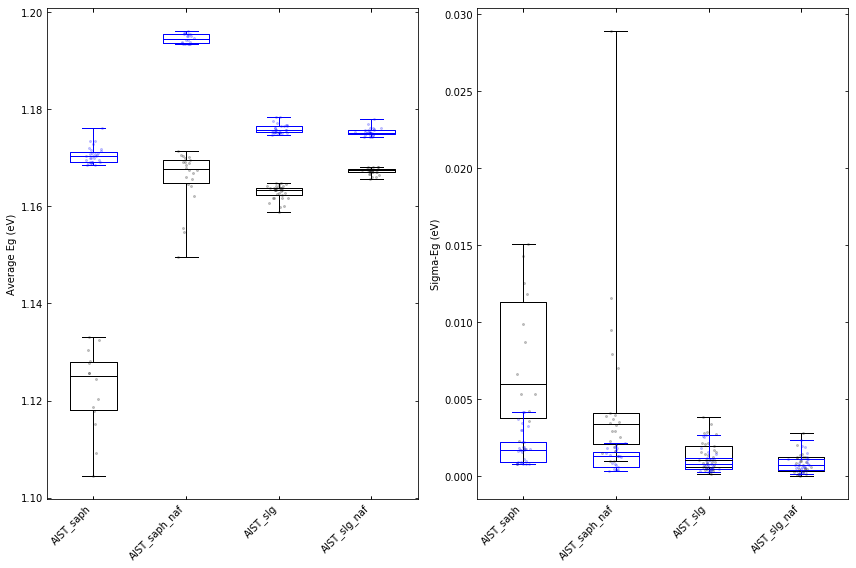

In [4]:
#### PLOT BOX PLOT DISTRIBUTIONS ########
fig, axes = plt.subplots(1,2,figsize=(12,8))
ax = axes.ravel()
flierprops = dict(marker='o', markersize=0, linestyle='none')
boxprops = dict(linestyle='-', linewidth=1)
colors=['black','blue']
ylab = ['Average Eg (eV)', 'Sigma-Eg (eV)', 'Voltage (V)', 'Current (A)']
#pos = [np.arange(num_samples)*0.5]*2
pos = range(num_samples)*2

for i in range(2):
    jitterx1 = []
    jittery1 = []
    jitterx2 = []
    jittery2 = []
    g1 = [None]*num_samples
    g2 = [None]*num_samples
    for ii in range(num_samples):
        g1[ii] =l_data[ii][i]
        g2[ii] =h_data[ii][i]
        jitterx1.extend(np.random.normal(ii, 0.05, size=len(g1[ii])))
        jittery1.extend(g1[ii])
        jitterx2.extend(np.random.normal(ii, 0.05, size=len(g2[ii])))
        jittery2.extend(g2[ii])
    #g1.append(g2)
    new = g1+g2
    bp = ax[i].boxplot(new,positions=pos,flierprops=flierprops,whis='range',boxprops=boxprops,widths=0.5)
    ax[i].plot(jitterx1, jittery1, 'ko', alpha=0.2,markersize=2)
    ax[i].plot(jitterx2, jittery2, 'bo', alpha=0.2,markersize=2)
    ax[i].tick_params(axis='both', direction='in', top='on', right='on')
    ax[i].set_ylabel(ylab[i])
    # Iterate over each of the elements changing the color
    elements = ['boxes','caps','whiskers','fliers','medians']
    for elem in elements:
        boxc = []
        num = int(np.floor(len(bp[elem])/2))
        for grp in range(2):
            boxc = boxc+[colors[grp]]*num
        for idx in xrange(len(bp[elem])):
            plt.setp(bp[elem][idx], color=boxc[idx])
    #axes[i,j].set_xticks(xticks)
    ax[i].set_xticklabels(sample_names, rotation='45', ha='right')
plt.tight_layout()
plt.show()

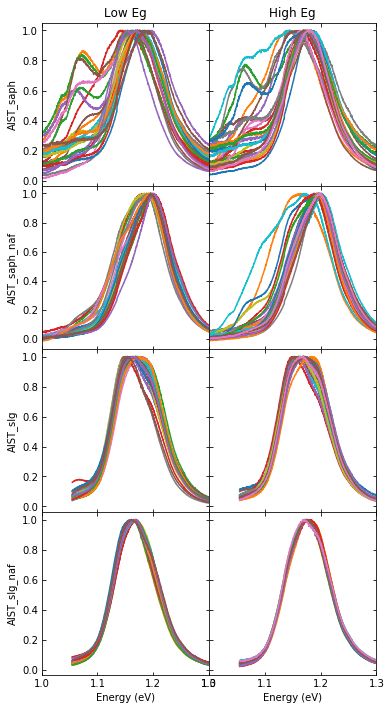

In [5]:
 #### PLOT BOX Spectra vs Group Number ########

l_spectra = [None]*num_samples
h_spectra = [None]*num_samples

for idx in range(num_samples):    
    spectra = all_pl[idx]
    
    for ii, d in enumerate(bl_list):
        bl = d.ravel()
        mean_spectra = []
        for i in range(1,np.max(bl)+1):
            spec = spectra[bl == i,:]
            norm_spec = spec/np.ones((spec.shape[1],1)).dot(np.max(spec,axis=1)*np.ones((1,spec.shape[0]))).T
            if (spec.shape[0] > 5) & (spec.shape[0] < 1000):
                mean_spectra.append(np.mean(spec,axis=0))
        if ii == 0:
            l_spectra[idx] = mean_spectra
        elif ii == 1:
            h_spectra[idx] = mean_spectra


fig, axes = plt.subplots(num_samples,2,figsize=(6,12),sharey='row',sharex='col')
ax = axes.ravel()
ylab = ['Low Eg Spectra', 'High Eg Spectra']
sample = 0
for i in range(num_samples):
    y1 = np.array(l_spectra[i])
    spec = np.array(y1)    
    norm_y1 = spec/np.ones((spec.shape[1],1)).dot(np.max(spec,axis=1)*np.ones((1,spec.shape[0]))).T
    y2 = np.array(h_spectra[i])
    spec = np.array(y2)
    norm_y2 = spec/np.ones((spec.shape[1],1)).dot(np.max(spec,axis=1)*np.ones((1,spec.shape[0]))).T
    ax[sample].plot(1240/all_pl_energy[i],norm_y1.T)
    ax[sample+1].plot(1240/all_pl_energy[i],norm_y2.T)
    ax[sample].tick_params(axis='both', direction='in', top='on', right='on')
    ax[sample+1].tick_params(axis='both', direction='in', top='on', right='on')
    ax[sample].set_xlim([1., 1.3])
    ax[sample+1].set_xlim([1., 1.3])
    ax[sample].set_ylabel(sample_names[i])
    sample+=2
    
fig.subplots_adjust(hspace=0.0,wspace=0.0)
axes[0,0].set_title('Low Eg')
axes[0,1].set_title('High Eg')
axes[3,0].set_xlabel('Energy (eV)')
axes[3,1].set_xlabel('Energy (eV)')
plt.show()

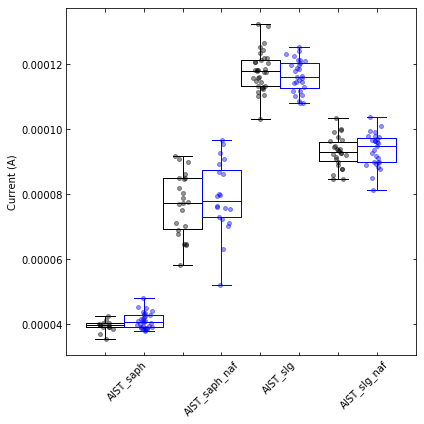

In [6]:
#### PLOT BOX SINGLE BOX PLOT ########
fig, ax = plt.subplots(1,1,figsize=(6,6))
#ax = axes.ravel()
flierprops = dict(marker='o', markersize=0, linestyle='none')
boxprops = dict(linestyle='-', linewidth=1)
colors=['black','blue']
ylab = ['Average Eg (eV)', 'Sigma-Eg (eV)', 'Voltage (V)', 'Current (A)']
#pos = [np.arange(num_samples)*0.5]*2
#pos = range(num_samples)
#pos += range(num_samples +0.5)
pos = [0, 1, 2, 3, 0.5, 1.5, 2.5, 3.5]
i = 3
jitterx1 = []
jittery1 = []
jitterx2 = []
jittery2 = []
g1 = [None]*num_samples
g2 = [None]*num_samples
for ii in range(num_samples):
    g1[ii] =l_data[ii][i]
    g2[ii] =h_data[ii][i]
    jitterx1.extend(np.random.normal(ii, 0.05, size=len(g1[ii])))
    jittery1.extend(g1[ii])
    jitterx2.extend(np.random.normal(ii+0.5, 0.05, size=len(g2[ii])))
    jittery2.extend(g2[ii])
#g1.append(g2)
new = g1+g2
bp = ax.boxplot(new,positions=pos,flierprops=flierprops,whis='range',boxprops=boxprops,widths=0.5)
ax.plot(jitterx1, jittery1, 'ko', alpha=0.4,markersize=4)
ax.plot(jitterx2, jittery2, 'bo', alpha=0.4,markersize=4)
ax.tick_params(axis='both', direction='in', top='on', right='on')
ax.set_ylabel(ylab[i])
# Iterate over each of the elements changing the color
elements = ['boxes','caps','whiskers','fliers','medians']
for elem in elements:
    boxc = []
    num = int(np.floor(len(bp[elem])/2))
    for grp in range(2):
        boxc = boxc+[colors[grp]]*num
    for idx in xrange(len(bp[elem])):
        plt.setp(bp[elem][idx], color=boxc[idx])
#axes[i,j].set_xticks(xticks)
ax.set_xticklabels(sample_names, rotation='45', ha='left')
#ax.set_ylim([0.22, 0.26])
plt.tight_layout()
plt.show()

# Fit PL Curves

Baseline Calc takes  0.008  seconds


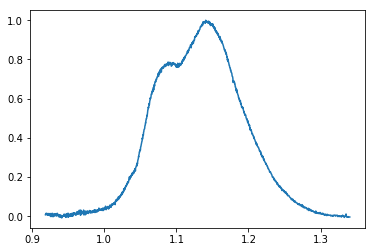

Curve Fitting takes  0.163  seconds
[ 1.17        0.53542813  0.06581772  1.14336758  0.47919123  0.03458619
  1.08098423  0.64258948  0.04056489]
0.747718454588


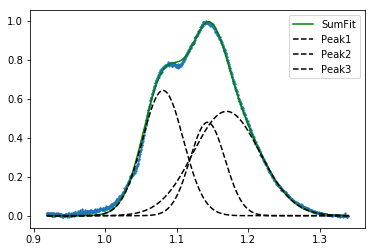

In [262]:
from scipy.optimize import curve_fit
from time import time
n = 0
x = 1240/np.array(all_pl_energy[n])
spec = np.array(all_pl[n])[5935,:]

#y = np.array(np.mean(spec,axis=0))-baseline(np.array(np.mean(spec,axis=0)),1)
t0 = time()
y = spec-baseline(spec,1)
print 'Baseline Calc takes ', round(time()-t0,3), ' seconds'
y /= np.max(y) 
plt.plot(x,y)
plt.show()

#https://stackoverflow.com/questions/26902283/fit-multiple-gaussians-to-the-data-in-python
def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y

def gaussian(x, ctr, amp, wid):
    return amp * np.exp( -((x - ctr)/wid)**2)

#guess = [1.7, 1.0, 0.05, 1.05, 0.5, 0.05] #Sapphire Substrates
#  #1.25, 0.5, 0.05

#3 curves -- wider FWHM -- narrower peak center
# guess = [1.2, 0.5, 0.05, 1.15, 0.5, 0.05, 1.08, 0.5, 0.05 ] 
# bounds = ([1.18, 0., 0., 1.13, 0., 0., 1.07, 0., 0.],[1.22, 1.0, 0.1, 1.17, 1.0, 0.1, 1.09, 1.0, 0.1])
# guess = [1.2, 0.5, 0.05, 1.15, 0.5, 0.05, 1.08, 0.1, 0.05 ] 
# bounds = ([1.18, 0., 0., 1.13, 0., 0., 1.06, 0., 0.],[1.22, 1.0, 0.1, 1.17, 1.0, 0.1, 1.1, 1.0, 0.1])
guess = [1.22, 0.5, 0.05, 1.15, 0.5, 0.05, 1.08, 0.1, 0.05 ] 
bounds = ([1.17, 0., 0., 1.1, 0., 0., 1.06, 0., 0.],[1.3, 1.0, np.inf, 1.18, 1.0, np.inf, 1.1, 1.0, 0.1])



#3 curves
#guess =[1.2, 0.5, 0.03, 1.15,  0.5,  0.03,  1.07,  0.25,  0.03]
#bounds = ([1.18, 0., 0., 1.1, 0., 0., 1.05, 0., 0.],[1.25, 1.0, 0.05, 1.18, 1.0, 0.05, 1.09, 1.0, 0.05])

#4 curves
# guess =[1.25, 0.5, 0.05, 1.2, 0.5, 0.05, 1.15,  0.5,  0.05,  1.07,  0.25,  0.05] 
#bounds = ([1.22, 0., 0., 1.18, 0., 0., 1.12, 0., 0., 1.05, 0., 0.],[1.27, 1., 0.05, 1.21, 1.0, 0.05, 1.175, 1.0, 0.05, 1.1, 1.0, 0.05])

t0 = time()
popt, pcov = curve_fit(func, x, y, p0=guess, bounds = bounds)
print 'Curve Fitting takes ', round(time()-t0,3), ' seconds'

print popt
R2 = 1-(np.sum(y-func(x, *popt))**2)/np.sum((y-np.mean(y))**2)
print R2
#print np.round(np.sqrt(np.diag(pcov))/popt*100,2)

fit = func(x, *popt)

plt.scatter(x, y, s=1.5)
plt.plot(x, fit , 'g-', label='SumFit')

for i in range(0,len(guess),3): 
    plt.plot(x, gaussian(x, popt[i], popt[i+1], popt[i+2]),'k--',label = 'Peak'+str(i/3+1))
#plt.plot(x, gaussian(x, popt[3], popt[4], popt[5]),'k-.',label = 'Peak2')
plt.legend()
plt.show()

In [258]:
#Fit 1
#guess =[1.2, 0.5, 0.03, 1.15,  0.5,  0.03,  1.07,  0.25,  0.03]
#bounds = ([1.19, 0., 0., 1.14, 0., 0., 1.06, 0., 0.],[1.21, 1.0, 0.05, 1.16, 1.0, 0.05, 1.08, 1.0, 0.05])
#centers = 1.2, 1.15, 1.07,  +/- 10 meV
#inteneisty = 0 --> 1
#sigma = 0 --> 50 meV

#Fit 2
# guess =[1.2, 0.5, 0.03, 1.15,  0.5,  0.03,  1.07,  0.25,  0.03]
# bounds = ([1.18, 0., 0., 1.13, 0., 0., 1.05, 0., 0.],[1.22, 1.0, 0.05, 1.17, 1.0, 0.05, 1.09, 1.0, 0.05])
#centers = 1.2, 1.15, 1.07,  +/- 20 meV
#inteneisty = 0 --> 1
#sigma = 0 --> 50 meV

#Fit 3
#guess =[1.2, 0.5, 0.03, 1.15,  0.5,  0.03,  1.07,  0.25,  0.03]
#bounds = ([1.18, 0., 0., 1.1, 0., 0., 1.05, 0., 0.],[1.25, 1.0, 0.05, 1.18, 1.0, 0.05, 1.09, 1.0, 0.05])

#Fit 4 wider FWHM -- narrower peak regions
# guess = [1.2, 0.5, 0.05, 1.15, 0.5, 0.05, 1.08, 0.5, 0.05 ] 
# bounds = ([1.18, 0., 0., 1.13, 0., 0., 1.06, 0., 0.],[1.22, 1.0, 0.1, 1.17, 1.0, 0.1, 1.1, 1.0, 0.1])

# #Fit 5 full FWHM range and FULL peak range (except peak 3)
# guess = [1.2, 0.5, 0.05, 1.15, 0.5, 0.05, 1.08, 0.1, 0.05 ] 
# bounds = ([1.1, 0., 0., 1.1, 0., 0., 1.06, 0., 0.],[1.25, 1.0, np.inf, 1.25, 1.0, np.inf, 1.1, 1.0, np.inf])

#Fit 6 full FWHM range and defined peak range


guess_2 = [1.175, 0.6, 0.05, 1.12, 0.4, 0.05, 1.08, 0.1, 0.05 ] 
bounds = ([1.17, 0., 0., 1.1, 0., 0., 1.06, 0., 0.],[1.3, 1.0, np.inf, 1.18, 1.0, np.inf, 1.1, 1.0, 0.1])
guess_1 = [1.2, 0.9, 0.05, 1.15, 0.1, 0.05, 1.08, 0.1, 0.05] 

# \/ \/ \/ \/  for n = 3
#guess_1 = [1.2, 0.1, 0.05, 1.15, 0.9, 0.05, 1.08, 0.1, 0.05] 



n = 1
x = 1240/np.array(all_pl_energy[n])
pl = np.array(all_pl[n])
fit_params = np.zeros((pl.shape[0],9))
fit_covs = np.zeros((pl.shape[0],9))
R2 = np.zeros((pl.shape[0],1)).ravel()
for idx in range(pl.shape[0]):
    guess = np.array(guess_1)

    
    if idx%500 == 0:
        print idx
    spec = np.array(pl[idx,:])
    y = spec-baseline(spec,1)
    y /= np.max(y)
    try:
        popt, pcov = curve_fit(func, x, y, p0=guess_1, bounds = bounds)
    except RuntimeError:
        #print 'iteration ', idx, ' failed to converge after first guess'
        try:
            popt, pcov = curve_fit(func, x, y, p0=guess_2, bounds = bounds)
        except RuntimeError:
            print 'iteration ', idx, ' failed to converge after 2 guesses'
            continue
    fit_params[idx,:] = popt
    fit_covs[idx,:] = np.sqrt(np.diag(pcov))
    R2[idx] = 1-(np.sum(y-func(x, *popt))**2)/np.sum((y-np.mean(y))**2)
    
#     # change the guess values for each iteration based on the previous pixel (or previous line)
#     if idx%len(all_x[n]) == 0:
#         guess = np.array(fit_params[idx/len(x),:])
#     else:
#         guess = np.array(fit_params[idx,:])
        
    
'''
Save the data and write the parameters in the log file
'''
fit_datetime = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
new_str = ''
print new_str
for idx in range(0,9,3):
    new_str += fit_datetime + '\t\t' + sample_names[n] + '\t\t' + str(bounds[0][idx]) +'-' +str(bounds[1][idx]) + '\t\t\t' + str(bounds[0][idx+2]) +'-' +str(bounds[1][idx+2]) + '\n'
print new_str
with open("fit_log.txt", "a") as myfile:
    myfile.write(new_str)
np.savetxt(sample_names[n]+"_"+fit_datetime+'_fit_coef.csv',fit_params,delimiter=',')
np.savetxt(sample_names[n]+"_"+fit_datetime+'_fit_covar.csv',fit_covs,delimiter=',')
np.savetxt(sample_names[n]+"_"+fit_datetime+'_fit_r2.csv',R2,delimiter=',')

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000

20171011-174412		AIST_saph_naf		1.17-1.3			0.0-inf
20171011-174412		AIST_saph_naf		1.1-1.18			0.0-inf
20171011-174412		AIST_saph_naf		1.06-1.1			0.0-0.1



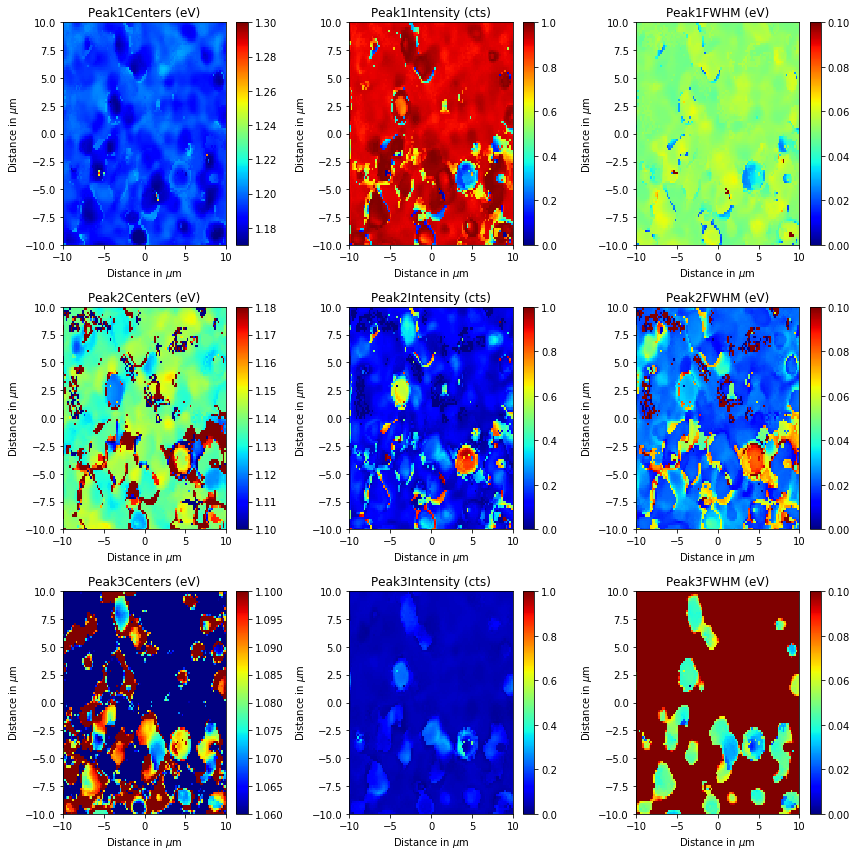

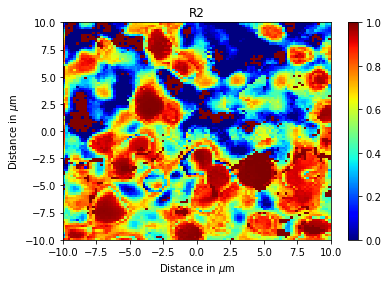

In [259]:
'''
Visualize The Distribuion of Fit Parameters
'''
x = all_x[n]
y = all_y[n]

# Make sure that peak 1 is always higher in energy than peak 2
test = fit_params[:,0] < fit_params[:,3]
fit_params[test,0:3] = np.array(fit_params[test,3:6])
fit_params[test,3:6] = np.array(fit_params[test,0:3])

fig, axes = plt.subplots(3,3,figsize=(12,12))
ax = axes.ravel()
for idx in range(0,9,3):
    map_num = idx
    pcm = ax[map_num].pcolor(x,y,switch_pks[:,map_num].reshape(len(x),len(y)),cmap='jet', vmin=bounds[0][map_num], vmax = bounds[1][map_num])#, vmin=np.min(doi[stamp]), vmax=np.max(doi[stamp]))
    ax[map_num].set_title('Peak' + str(idx/3+1) + 'Centers (eV)')
    ax[map_num].set_xlabel('Distance in $\mu$m')
    ax[map_num].set_ylabel('Distance in $\mu$m')     
    fig.colorbar(pcm,ax = ax[map_num])
    map_num = idx+1
    pcm = ax[map_num].pcolor(x,y,switch_pks[:,map_num].reshape(len(x),len(y)),cmap='jet', vmin=bounds[0][map_num], vmax = bounds[1][map_num])#, vmin=np.min(doi[stamp]), vmax=np.max(doi[stamp]))
    ax[map_num].set_title('Peak' + str(idx/3+1) + 'Intensity (cts)')
    ax[map_num].set_xlabel('Distance in $\mu$m')
    ax[map_num].set_ylabel('Distance in $\mu$m')
    fig.colorbar(pcm,ax = ax[map_num])
    map_num = idx+2
    pcm = ax[map_num].pcolor(x,y,switch_pks[:,map_num].reshape(len(x),len(y)),cmap='jet',vmin=0, vmax = 0.1)#, vmin=np.min(doi[stamp]), vmax=np.max(doi[stamp]))
    ax[map_num].set_title('Peak' + str(idx/3+1) + 'FWHM (eV)')
    ax[map_num].set_xlabel('Distance in $\mu$m')
    ax[map_num].set_ylabel('Distance in $\mu$m') 
    fig.colorbar(pcm,ax = ax[map_num])
plt.tight_layout()
plt.show()


plt.pcolor(x,y,R2.reshape(len(x),len(y)),cmap='jet', vmin=0,vmax=1)
plt.colorbar()
plt.title('R2')
plt.xlabel('Distance in $\mu$m')
plt.ylabel('Distance in $\mu$m')

plt.show()

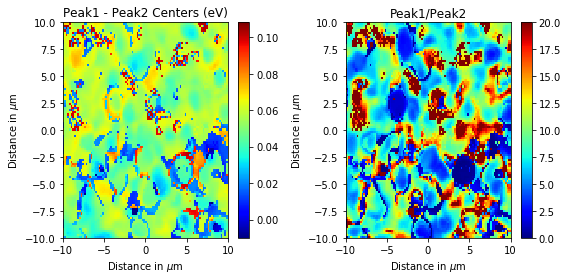

In [245]:
center_diff = fit_params[:,0]-fit_params[:,3]
intensity_ratio = fit_params[:,1]/fit_params[:,4]
intensity_ratio[np.isnan(intensity_ratio)]=1

fig,axes = plt.subplots(1,2,figsize=(8,4))
ax = axes.ravel()
map_num = 0
pcm = ax[map_num].pcolor(x,y,center_diff.reshape(len(x),len(y)),cmap='jet')#, vmin=np.min(doi[stamp]), vmax=np.max(doi[stamp]))
ax[map_num].set_title('Peak1 - Peak2 Centers (eV)')
ax[map_num].set_xlabel('Distance in $\mu$m')
ax[map_num].set_ylabel('Distance in $\mu$m')     
fig.colorbar(pcm,ax = ax[map_num])
map_num = 1
if n == 3:
    pcm = ax[map_num].pcolor(x,y,intensity_ratio.reshape(len(x),len(y)), cmap='jet', norm=mpl_colors.LogNorm(vmin=intensity_ratio.min(), vmax=intensity_ratio.max()))#, vmin=np.min(doi[stamp]), vmax=np.max(doi[stamp]))
else:
    pcm = ax[map_num].pcolor(x,y,intensity_ratio.reshape(len(x),len(y)), cmap='jet', vmin=0, vmax = 20)
ax[map_num].set_title('Peak1/Peak2')
ax[map_num].set_xlabel('Distance in $\mu$m')
ax[map_num].set_ylabel('Distance in $\mu$m')
fig.colorbar(pcm,ax = ax[map_num])
plt.tight_layout()
plt.show()



In [252]:
test = fit_params[:,0] < fit_params[:,3]
fit_params[test,0:3] = np.array(fit_params[test,3:6])
fit_params[test,3:6] = np.array(fit_params[test,0:3])

